In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange
from module import *

In [2]:
data_rows = {
    "e":  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1},
    "r":  {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0},
    "c":  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1},
    "cr": {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0},
    "l":  {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1},
    "lr": {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0},
    "lc": {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1},
    "f":  {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0},
    "off":{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
}
numbers = {
    0: "f lr lr lr lr lr f",
    1: "c c c c c c c",
    2: "f r r c l l f",
    3: "lc r r c r r lc",
    4: "lr lr lr f r r r",
    5: "f l l c r r f",
    6: "f l l f lr lr f",
    7: "f r r c c c c",
    8: "c lr lr c lr lr f",
    9: "c lr lr cr r c l",
}
empty = np.array([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]])

numbers_rows = {k: [data_rows[vv] for vv in v.split(" ")] for k, v in numbers.items()}

from ipywidgets import SelectMultiple, Select, Button, HBox, VBox, Output, IntRangeSlider, Checkbox, Accordion
def ui(data):
    def update_graph(b):
        fig, ax = plt.subplots(figsize=(8,8))
        s = np.concatenate(([x.value for x in select_nodes]))
        if np.isin('---', s):
            s = s[np.where(s != '---')].astype(int)
        for n in s:
            t = data.index.tolist()
            ax.step(t[xw.value[0]:xw.value[1]], data[n][xw.value[0]:xw.value[1]])
        ax.legend([int(n) for n in s])
        with graph:
            graph.clear_output()
            display(plt.show())


    graph = Output()
    layer_select = Select(
        options=net.nodes.layer.unique(),
        value=0,
        description='Слой'
    )

    type_chboxs = []
    for t in net.nodes.type.unique():
        type_chboxs.append(Checkbox(
            value=True,
            description=t,
            disabled=False
        ))
    select_nodes = []
    for t in type_chboxs:
        v = t.value
        if v:
            select_nodes.append(
                SelectMultiple(
                    options=np.insert(np.array(net.nodes.query(f"type=='{t.description}'").index.tolist(),dtype=object), 0, '---'),
                    description=t.description
                )
            )
            select_nodes[-1].rows = min(len(select_nodes[-1].options), 10)

    def on_layer_change(change):
        select_nodes = []
        for t in type_chboxs:
            v = t.value
            if v:
                select_nodes.append(
                    SelectMultiple(
                        options=np.insert(np.array(net.nodes.query(f"type=={t.description}").index.tolist(),dtype=object), 0, '---'),
                        description=t.description
                    )
                )
                select_nodes[-1].rows = min(len(select_nodes[-1].options), 10)

    layer_select.observe(on_layer_change, names='value')

    xw = IntRangeSlider(
        min=data.index.min(),
        max=data.index.max(),
        value=(data.index.min(), data.index.max()),
        description='Окно просмотра',
        disabled=False
    )
    select = Accordion(children=[VBox(type_chboxs), VBox(select_nodes)])
    select.selected_index=1
    select.set_title(0, 'Типы')
    select.set_title(1, 'Ноды')
    xw.observe(update_graph, names='value')
    [x.observe(update_graph, names='value') for x in select_nodes]
    draw = Button(description='Draw')
    draw.on_click(update_graph)
    return HBox((VBox((xw,select,draw)), graph))

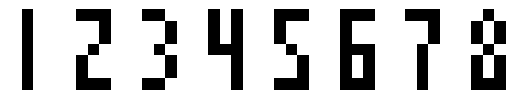

In [3]:
from matplotlib import gridspec

gs = gridspec.GridSpec(1, 8)
numbers_rows_18 = {k:v for k, v in numbers_rows.items() if 0 < k < 9}
for i, n in enumerate(numbers_rows_18.values()):
    ax = plt.subplot(gs[i])
    ax.imshow(np.abs(1- pd.DataFrame(n).values[:, 0:3]), cmap="gray")
    ax.set_yticks(())
    ax.set_xticks(())
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    plt.subplots_adjust(wspace=.9)



In [4]:
row_time = 10
silent_time = 100
params_dendrites = {
    "tau_leak": 2.28*row_time, 
    "tau_inhibitory": 1,
    "tau_refractory": 1,
    "tau_ltp": 3.15*row_time, 
    "thres": 1150,
    "ainc": 0.7, 
    "adec": -3, 
    "wmax": 195, 
    "wmin": 1,
    "learning": True,
    "wta": True,
    "layer_type": "ttron"
}

# 1 Подготовка новой сети

## Генерация

In [5]:
def new_network(**ps):
    params = params_dendrites.copy()
    params.update(ps)
    net = SpikeNetworkSim(inputs_l=6, dt=1)
    teacher_nodes, who_is_who = net.ttron_layer(num_nodes=4, num_cat_inputs=4, delay_depth=5, **params)
    return net, teacher_nodes, who_is_who
net, teacher_nodes, who_is_who = new_network()

In [6]:
net.nodes.loc[net.nodes.type=="presynaptic"]

,type,listening,broadcasting,priority,layer
77,presynaptic,"[0, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35]",[80],2,0
84,presynaptic,"[0, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35]",[87],2,0
91,presynaptic,"[0, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35]",[94],2,0
98,presynaptic,"[0, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35]",[101],2,0


# 0 Инициализация наборов данных

## Обучающий датасет

In [7]:

genome = {
    1:{35:0, 65:0}, 
    2:{35:1, 65:2},
    3:{35:1, 65:1}, 
    4:{35:3, 65:1}, 
    5:{35:2, 65:1},
    6:{35:2, 65:3},
    7:{35:1, 65:0}, 
    #8:{25:0, 45:0}, 
    #9:{25:0, 45:1}, 
    #0:{35:4, 65:4}
}
pattern_sights = {teacher_nodes[k]: (np.concatenate([(g[35], g[65]) for g in genome.values()])==k).sum() for k in range(4)}


In [8]:
def gen_test(n_num):
    seq_data = []
    seq_labels = []
    a = None
    for n in range(n_num):
            a = np.random.randint(1, 8)
            seq_data+=[x.copy() for x in numbers_rows[a]]
            seq_labels+=[a for _ in numbers_rows[a]]
            seq_labels.append(-1)
            seq_data.append(data_rows["off"].copy())

    #genome = {}
    #for x in np.unique(seq_labels):
    #    genome[x] = np.random.randint(len(teacher_nodes))

    nseq_d = []
    nseq_l = []

    for d, l in zip(seq_data, seq_labels):
        if l != -1:
            t = row_time
        else:
            t = silent_time
        nseq_d.append(d.copy())
        nseq_l.append(l)
        for i in range(t-1):
            nseq_d.append(data_rows["off"].copy())
            nseq_l.append(l)

    seq_data = nseq_d
    seq_labels = nseq_l

    d_p = seq_labels[0]
    step = 1
    for i, d in enumerate(seq_labels[1:]):
        seq_data[i].update({k:0 for k in teacher_nodes})
        if d_p == -1 and d != d_p:
            step = 0
        if d in genome:
            if step in genome[d]:
                seq_data[i][teacher_nodes[genome[d][step]]] = 1
        d_p = d
        step += 1
    return seq_data

## Тестовый датасет

In [9]:
nseq_d = []
nseq_l = []
test_data = []
test_labels = []
a = None
for n in range(1, 9):
    a = n
    test_data+=[x.copy() for x in numbers_rows[a]]
    test_labels+=[a for _ in numbers_rows[a]]
    test_labels.append(-1)
    test_data.append(data_rows["off"].copy())

for d, l in zip(test_data, test_labels):
    if l != -1:
        t = row_time
    else:
        t = silent_time
        
    nseq_d.append(d.copy())
    nseq_l.append(l)
    for i in range(t-1):
        nseq_d.append(data_rows["off"].copy())
        nseq_l.append(l)

test_data = nseq_d
test_labels = nseq_l
step = 0
d_p = 0
for i, d in enumerate(test_labels[1:]):
    test_data[i].update({k:0 for k in teacher_nodes})
    if d_p == -1 and d != d_p:
        step = 0
    if d in genome:
        if step<25:
            test_data[i][teacher_nodes[genome[d][35]]] = 1
        elif step<35:
            test_data[i][teacher_nodes[genome[d][35]]] = 1
            test_data[i][teacher_nodes[genome[d][65]]] = 1     
        else:
            test_data[i][teacher_nodes[genome[d][65]]] = 1            
    d_p = d
    step += 1

# 2 Обучение

## Цикл обучения

In [10]:
ZOO_POP = 0

In [11]:
pattern_sights

{72: 3, 73: 6, 74: 3, 75: 2}

In [12]:
zoo = []
weights_variance = []
net, _, _ = new_network()
dist = []
variations = []

for j in trange(ZOO_POP):
    start_weights = net.weights.weights.copy()
    
    #temp = 0.2
    
    #params_update = {
    #    "tau_leak": np.random.randint(-2*row_time, 2*row_time)*temp+params_dendrites["tau_leak"], 
    #    "tau_ltp": np.random.randint(-3*row_time, 3*row_time)*temp+params_dendrites["tau_ltp"], 
    #    "wmax": np.random.randint(100, 255)*temp+params_dendrites["wmax"]*(1-temp), 
   # }

    net, _, _ = new_network()
    #net.weights = start_weights.copy()
    error_agg = error_agg_min = 100
    for section in range(15):
        net.layer_params["learning"][-1] = True
        out_learn = net.feed_raw(gen_test(10))
        net.layer_params["learning"][-1] = False
        out_test = net.feed_raw(test_data)
        error = net.error(teacher_nodes, pattern_sights=pattern_sights)
        e = {k: v.copy() for k, v in error.items()}
        mins = []
        for _ in error.keys():
            b = {k: min(e[k], key=lambda x: abs(e[k][x])) for k in e.keys()}
            a = min(b, key=lambda x: abs(e[x][b[x]]))
            mins.append(e[a][b[a]])
            del e[a]
            for k in e.keys():
                del e[k][b[a]]
        mins = np.array(mins)
        error_agg = (mins.mean())
        if error_agg > error_agg_min*1.2:
            ...
            #break
        error_agg_min = min(error_agg, error_agg_min)
        weights_variance.append(
            {"sp": j, "sec": section, "error": error.copy(), "weights": net.weights.weights.copy(), "error_agg": error_agg}
        )
    #variations.append(params_update.copy())
    
    dist.append((start_weights-net.weights.weights).abs().sum())
d2 = pd.DataFrame(weights_variance)

0it [00:00, ?it/s]


In [13]:
a = np.array([x.mean()/12 for x in dist])
a.mean(), a.std()

C:\Users\Кормак\AppData\Local\Temp\ipykernel_3856\3987556182.py:2: RuntimeWarning: Mean of empty slice.
  a.mean(), a.std()
H:\JupyterLab\spikesim\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
H:\JupyterLab\spikesim\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
H:\JupyterLab\spikesim\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
H:\JupyterLab\spikesim\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(nan, nan)

In [14]:
plt.plot(d2.query("sp==18").sort_values("sec").error_agg.values)

UndefinedVariableError: name 'sp' is not defined

In [ ]:
for i in range(ZOO_POP):
    plt.plot(d2.query("sp==@i").sort_values("sec").error_agg.values)

In [15]:
import ipywidgets as widgets

def arrowed_spines(fig, ax):

    xmin, xmax = ax.get_xlim() 
    ymin, ymax = ax.get_ylim()

    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)

    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./20.
    hl = 40.
    lw = .7 # axis line width
    ohg = 0.3 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg, 
             length_includes_head= True, clip_on = False, zorder=999) 

    ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
             head_width=yhw, head_length=yhl, overhang = ohg, 
             length_includes_head= True, clip_on = False, zorder=999)
#загрузить исходные веса
inputs = [[] for _ in range(4)]
array = np.array
presynaptic = net.nodes.loc[net.nodes.type=="presynaptic"].index.tolist()
save = {77: array([134, 103, 45,   53,  30,  96, 14, 126, 153,  185,  175,  36]),
 84: array([ 100,  173,   1,  158, 3, 153, 147, 70, 127, 1,   172,  20]),
 91: array([199, 135,  34,   5,  40, 102, 154,  73,  24, 116,   3,  86]),
 98: array([56,  89,  51, 130,  2, 116, 68,   115, 110,  182, 91,   80])}

best_weights = save#
#best_weights=d2.loc[d2["error_agg"].abs().sort_values().index[3]].weights
weights = best_weights

for i in range(4):
    for _ in range(12):
        inputs[i].append(widgets.BoundedIntText(
            value=best_weights[presynaptic[i]][_],
            min=1,
            max=255,
            step=1,
            description='',
            layout=widgets.Layout(width='50px', height='30px')
        ))
    inputs[i].append(widgets.BoundedFloatText(
        value=1,
        min=0,
        max=10,
        step=0.1,
        description='Cf'
    ))
#
def rescale(nr):
    def inner(_):
        global weights
        for nc in range(12):
            inputs[nr][nc].value = int(inputs[nr][12].value*weights[presynaptic[nr]][nc])
    return inner
#

scalers = []
for i in range(4):    
    scalers.append(rescale(i))
    inputs[i][-1].observe(scalers[i])
#по нажатию кнопки - обновить всё
def get_weights():
    global weights
    weights = dict(list(zip(presynaptic, [np.array([c.value for c in row[:12]]) for row in inputs])))
    return weights

def run_new_weights(_):
    net, _, _ = new_network()
    net.weights.weights = get_weights()
    net.layer_params["learning"][-1] = False
    
    out_test = net.feed_raw(test_data)
    fig, ax = plt.subplots(figsize=(6,3))
    s = [x+3 for x in presynaptic]
    for n in s:
        ax.step(out_test.index.tolist(), out_test[n], lw=2)
    #ax.legend([1, 2, 3, 4], loc="center right")
    ax.set_xlim(0, 1399)
    ax.set_ylim(0.001, 1.2)
    ax.set_yticks(())
    arrowed_spines(fig, ax)
    ax.spines[['left', 'bottom']].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    with graph:
        graph.clear_output()
        display(plt.show())
    for row in inputs:
        row[12].value = 1

draw = Button(description="Draw")
draw.on_click(run_new_weights)
graph = Output()
run_new_weights(None)
VBox([HBox(i) for i in inputs]+[draw, graph])

<Figure size 640x480 with 0 Axes>

In [22]:
def prep(data):
    r = data.copy()
    for i in range(len(r), 0, -1):
        for _ in range(9):
            r.insert(i, 'off')
    return r

net, _, _ = new_network()
net.weights.weights = get_weights()
net.layer_params['learning'][-1] = False
net.layer_params['thres'][-1] = 1500
data = ['c', 'lr', 'f']
out = net.feed_raw([data_rows[x] for x in prep(data[::-1])])
out2 = net.feed_raw([data_rows[x] for x in prep(data)])

In [23]:
a

array([], dtype=float64)

In [24]:
out[node]

NameError: name 'node' is not defined

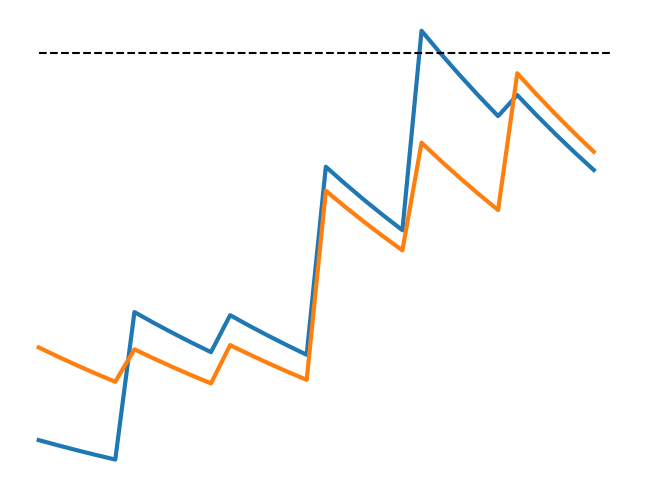

In [29]:
data = ['c', 'lr', 'f']
node = presynaptic[1]
a = out[node]
b = out2[node]

fig, ax = plt.subplots(layout='constrained')

ax.plot(a, lw=3)
ax.plot(b, lw=3)
ax.plot((0,30), (1150, 1150), '--k')
#ax.grid(True)
ax.spines[["left", "top", "bottom", "right"]].set_visible(False)
ax.set_yticks(())
ax.set_xticks(())
plt.savefig("direction.png", dpi=500)

In [26]:
((b-a).max()-(b-a).min())

463.68971040408826

In [27]:
data[::-1]

['f', 'lr', 'c']

In [ ]:
a = np.array([1,2,3,4,5,6, 1,2,3,4,5,6])

In [ ]:
a.reshape(2, 6)

In [ ]:
np.array([1,2,3]),np.array([3,2,1]))

In [ ]:
a = get_weights()[98].reshape((2,6))[[1,0]]
a[:,3:]-a[:,:3]

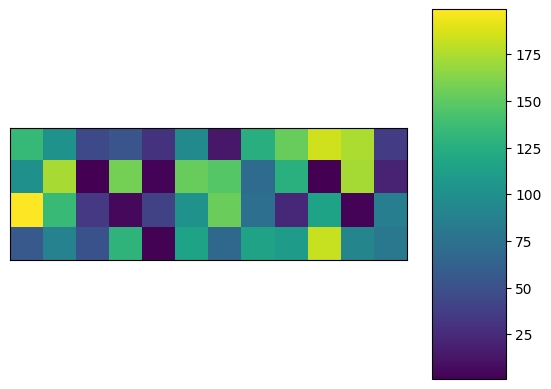

In [31]:
a= plt.imshow(get_weights().values())
plt.xticks(())
plt.yticks(())
plt.colorbar(a, aspect=5, )
plt.savefig("dendrite_weights.png", dpi=500)